# Problem Statement:

Users can spend most of the hours scrolling through hundreds, sometimes thousands of anime’s never finding an content they like. Our objective is to build recommendation systems which recommend anime's considering or based on their likes and needs in order to create a better streaming environment that boosts revenue and increases the time spent on a Ibsite. 

# Data Dictionary

**1) anime_data:**

`anime_id` - unique id identifying an anime.

`name` - full name of anime.

`genre` - comma separated list of genres for this anime.

`type` - movie, TV, OVA, etc.

`episodes` - how many episodes in this show. (1 if movie).

`rating` - average rating out of 10 for this anime.

`members` - number of community members that are in this anime's "group".

**2) rating_data:**

`user_id` - non identifiable randomly generated user id.

`anime_id` - the anime that this user has rated.

`rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

#  Import Libraries 


In [1]:
!pip install kneed


In [2]:
!pip install mlxtend

In [3]:
!pip install apyori

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns 
from warnings import filterwarnings
filterwarnings('ignore')
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from mlxtend.frequent_patterns import apriori,association_rules
import re
import string
from apyori import apriori

#  Read Data 

In [5]:
anime=pd.read_csv('anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [7]:
rating=pd.read_csv('rating.csv',sep=',')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [8]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


# Exploratory Data Analysis 

##  Preparing the Dataset

### Data Cleaning 

In [9]:
anime['name'].unique()[3:10]

array(['Steins;Gate', 'Gintama&#039;',
       'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter (2011)', 'Ginga Eiyuu Densetsu',
       'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare',
       'Gintama&#039;: Enchousen'], dtype=object)

In [10]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)
    
    return text

anime['name'] = anime['name'].apply(text_cleaning)

In [11]:
anime['name'] = anime['name'].apply(text_cleaning)

In [12]:
anime['name'].unique()[3:10]

array(['SteinsGate', 'Gintama039',
       'Haikyuu Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
       'Hunter x Hunter 2011', 'Ginga Eiyuu Densetsu',
       'Gintama Movie Kanketsuhen  Yorozuya yo Eien Nare',
       'Gintama039 Enchousen'], dtype=object)

In [13]:
anime.episodes.unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [14]:
anime.episodes.replace({'Unknown':np.nan},inplace=True)

###  Merging the datasets

In [15]:
df=pd.merge(anime,rating,on='anime_id')
df.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


In [16]:
df.rename(columns={'rating_x':'avg_rating','rating_y':'user_rating'},inplace=True)
df.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


### Data Info

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813727 entries, 0 to 7813726
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   name         object 
 2   genre        object 
 3   type         object 
 4   episodes     object 
 5   avg_rating   float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 596.1+ MB


### Data Dimensions

In [18]:
anime.shape

(12294, 7)

In this dataset I have 12294 records across 7 features

In [19]:
rating.shape

(7813737, 3)

In this dataset I have 7813737 records across 3 features

In [20]:
df.shape

(7813727, 9)

In this dataset I have 7813727 records across 3 features

###  Data Types 

In [21]:
df.dtypes

anime_id         int64
name            object
genre           object
type            object
episodes        object
avg_rating     float64
members          int64
user_id          int64
user_rating      int64
dtype: object

There are 4 `objects`, 1 `float` and 4 `int` data types attributes.

As anime_id and user_id are unique values I need to convert it into `object` data type.

In [22]:
df['anime_id']=df.anime_id.astype('object')
df['user_id']=df.user_id.astype('object')

In [23]:
df.dtypes

anime_id        object
name            object
genre           object
type            object
episodes        object
avg_rating     float64
members          int64
user_id         object
user_rating      int64
dtype: object

Now there are 6 `objects`, 2 `int` and 1 `float` attributes.

### Missing Values 

In [24]:
missing_value = pd.DataFrame({
    'Missing Value': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df))*100
})

In [25]:
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
genre,110,0.001408
episodes,8,0.000102
avg_rating,6,0.000077
type,4,0.000051
anime_id,0,0.000000
name,0,0.000000
members,0,0.000000
user_id,0,0.000000
user_rating,0,0.000000


There are few missing values in `genre`,`episodes`,`avg_rating` and `type`.

In [26]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes    340
rating      230
members       0
dtype: int64

There are few missing values in `genre`,`episodes`,`avg_rating` and `type`.

**Missing Values treatment**

In [27]:
# I can't replace the nan values with mean or median as it's unique for each movie
# So I will drop the null values rows
df.dropna(inplace=True)
anime.dropna(inplace=True)

In [28]:
df.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
avg_rating     0
members        0
user_id        0
user_rating    0
dtype: int64

In [29]:
anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Now, There are no null values in the dataset.

### Duplicate Data 

In [30]:
duplicate = df.duplicated(subset=['anime_id','user_id']).sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 7 duplicated rows in the data


In [31]:
duplicate = anime.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


**Getting rid of duplicate data**

In [32]:
df.drop_duplicates(subset=['anime_id','user_id'],inplace=True)

**Checking for duplicate data after removal of duplicates**

In [33]:
duplicate = df.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


### Indexing 

In [34]:
df.shape

(7813600, 9)

There are `7813604` records after removing missing values and duplicates.

In [35]:
df.tail()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
7813722,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,39532,-1
7813723,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,48766,-1
7813724,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,60365,4
7813725,26081,Yasuji no Pornorama Yacchimae,Hentai,Movie,1,5.46,142,27364,-1
7813726,26081,Yasuji no Pornorama Yacchimae,Hentai,Movie,1,5.46,142,48766,-1


In [36]:
df.reset_index(drop=True,inplace=True)
df.tail()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
7813595,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,39532,-1
7813596,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,48766,-1
7813597,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175,60365,4
7813598,26081,Yasuji no Pornorama Yacchimae,Hentai,Movie,1,5.46,142,27364,-1
7813599,26081,Yasuji no Pornorama Yacchimae,Hentai,Movie,1,5.46,142,48766,-1


### Final Dataset 

In [37]:
df.shape

(7813600, 9)

In [38]:
df.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


The final dataset has **7813604 records and 9 features with no missing and duplicate values**

In [39]:
df.describe()

,avg_rating,members,user_rating
count,7.813600e+06,7.813600e+06,7.813600e+06
mean,7.653158e+00,1.786231e+05,6.144076e+00
std,6.729737e-01,1.881761e+05,3.727792e+00
min,1.670000e+00,2.900000e+01,-1.000000e+00
25%,7.270000e+00,4.403000e+04,6.000000e+00
50%,7.680000e+00,1.104700e+05,7.000000e+00
75%,8.130000e+00,2.442680e+05,9.000000e+00
max,9.500000e+00,1.013917e+06,1.000000e+01


From the above table , I can infer:

1. The minimum avg_rating is 1.67 and the maximum avg_rating is 9.5.

2. The number of members ranges from 29 to 1013917.

3. Users rating ranges from -1 to 10. So, I will replace -1 with NaN and drop the rows.

In [40]:
df[df.user_rating==-1].shape

(1476463, 9)

In [41]:
df.user_rating.replace({-1:np.nan},inplace=True)

In [42]:
df.isnull().sum()

anime_id             0
name                 0
genre                0
type                 0
episodes             0
avg_rating           0
members              0
user_id              0
user_rating    1476463
dtype: int64

In [43]:
df.dropna(inplace=True)

In [44]:
df.isnull().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
avg_rating     0
members        0
user_id        0
user_rating    0
dtype: int64

In [45]:
df.shape

(6337137, 9)

In [46]:
df.describe()

,avg_rating,members,user_rating
count,6.337137e+06,6.337137e+06,6.337137e+06
mean,7.675014e+00,1.845764e+05,7.808545e+00
std,6.699039e-01,1.909528e+05,1.572436e+00
min,2.000000e+00,3.300000e+01,1.000000e+00
25%,7.290000e+00,4.680300e+04,7.000000e+00
50%,7.700000e+00,1.170910e+05,8.000000e+00
75%,8.150000e+00,2.563250e+05,9.000000e+00
max,9.370000e+00,1.013917e+06,1.000000e+01


**Interpretation:**

1. The minimum avg_rating is 2 and the maximum avg_rating is 9.37.

2. The number of members ranges from 33 to 1013917.

3. Users rating ranges from 1 to 10.

**Categorical Variables**

In [47]:
df.describe(include='object')

,anime_id,name,genre,type,episodes,user_id
count,6337137,6337137,6337137,6337137,6337137,6337137
unique,9890,9869,3048,6,177,69600
top,1535,Death Note,"Comedy, School, Slice of Life",TV,12,42635
freq,34226,34226,49850,4364286,1420729,3747


### Correlation

In [48]:
corr_matrix=df.corr()
corr_matrix

,avg_rating,members,user_rating
avg_rating,1.000000,0.541075,0.410680
members,0.541075,1.000000,0.232404
user_rating,0.410680,0.232404,1.000000


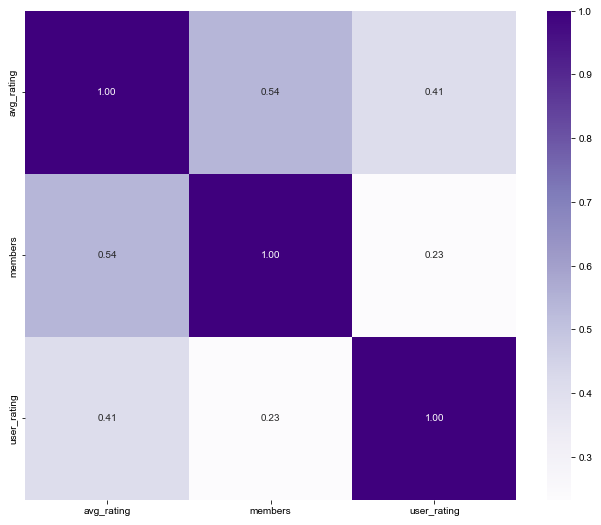

In [49]:
plt.figure(figsize=(11,9))
sns.heatmap(corr_matrix, cmap='Purples', annot=True, fmt=".2f")
sns.set(font_scale=1.5)

**Inferences:**

Members and avg_rating have a positive relationship.i.e. **0.54**. Because as the number of members increase avg rating of the anime will also increase.

There is no Strong relationship betIen any attributes. 

In [50]:
nonull_anime=df.copy()
nonull_anime.dropna(inplace=True)
from collections import defaultdict

all_genres = defaultdict(int)

for genres in nonull_anime['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

**Top 10 anime based on rating counts**

In [51]:
df_count = df.groupby(by = ['name'])['user_rating'].count().reset_index()[['name', 'user_rating']]
df_count.rename(columns = {'user_rating': 'totalRatingCount'},inplace=True)
df_count.head()

,name,totalRatingCount
0,0,17
1,0008,34
2,001,10
3,009 ReCyborg,238
4,0091,244


Text(0, 0.5, 'User Rating count')

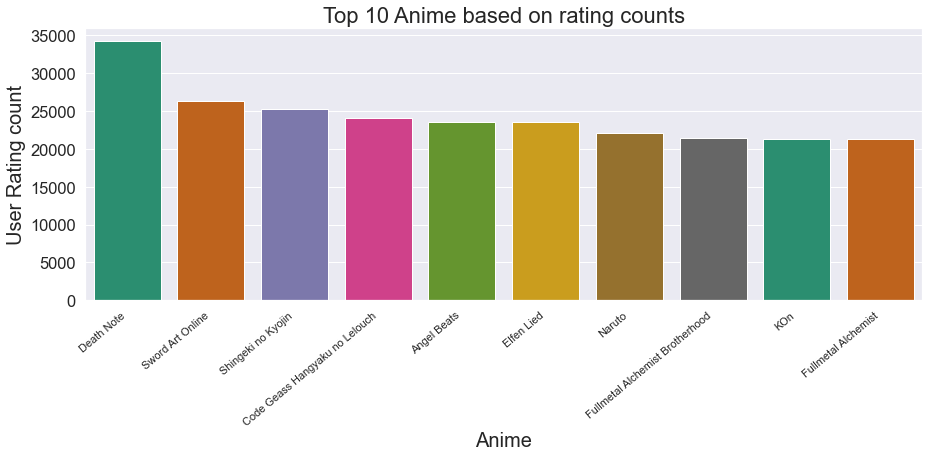

In [52]:
top10_animerating=df_count[['name', 'totalRatingCount']].sort_values(by = 'totalRatingCount',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="totalRatingCount", data=top10_animerating, palette="Dark2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on rating counts',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('User Rating count', fontsize = 20)

From the graph I can infer:
    
Based on the user rating I can see that`Death Note` have been rated the most folloId by `Sword Art Online` and `Shingeki no Kyojin`.

**Top 10 animes based on community size**

In [53]:
df_data=df.merge(df_count, left_on = 'name', right_on = 'name', how = 'left')
df_data.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating,totalRatingCount
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0,1961
1,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0,1961
2,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0,1961
3,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0,1961
4,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0,1961


In [54]:
df_data.duplicated(subset=['name']).sum()

6327268

In [55]:
anime1=df_data.drop_duplicates(subset=['name'])
anime1.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating,totalRatingCount
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0,1961
1961,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,3,10.0,21494
23455,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,43,10.0,1188
24643,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572,5,9.0,17151
41794,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,5,9.0,3115


Text(0, 0.5, 'Community Size')

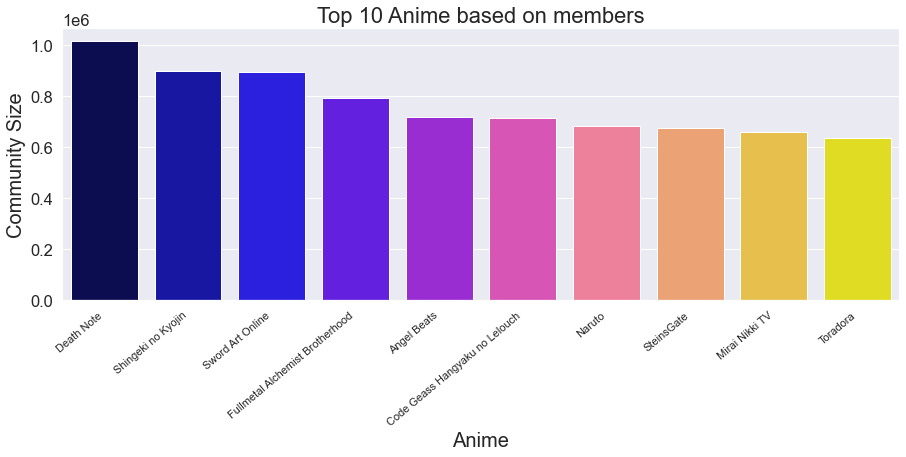

In [56]:
top10_animemembers=anime1[['name', 'members']].sort_values(by = 'members',ascending = False).head(10)
plt.figure(figsize=(15,5))
ax=sns.barplot(x="name", y="members", data=top10_animemembers, palette="gnuplot2")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11, rotation=40, ha="right")
ax.set_title('Top 10 Anime based on members',fontsize = 22)
ax.set_xlabel('Anime',fontsize = 20) 
ax.set_ylabel('Community Size', fontsize = 20)

**Interpretation:**
    
`Death Note` as the huge community size folloId by `Shingeki no kyojin` and `Sword Art Online`.

### Distribution of rating <a id='analyze_tar_var'></a>

Text(0.5, 1.0, 'Rating of users')

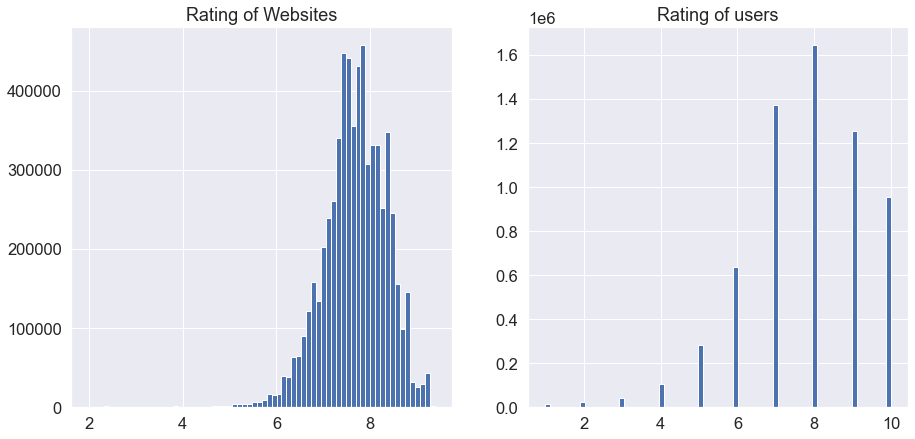

In [57]:
plt.figure(figsize = (15, 7))
plt.subplot(1,2,1)
df['avg_rating'].hist(bins=70)
plt.title("Rating of Websites")
plt.subplot(1,2,2)
df['user_rating'].hist(bins=70)
plt.title("Rating of users")

**Interpretation:**

Most of the ratings are spread betIen 6-10.

The mode of the distribution is around 7.5-8.0.

Both the distribution are left skeId.

**Percentage of users in each type**

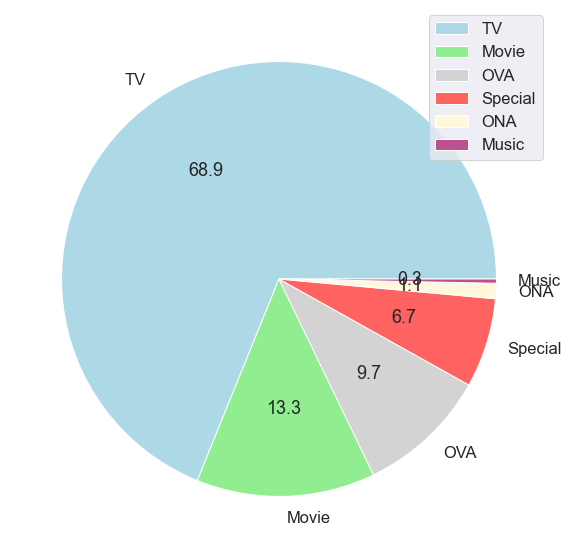

In [58]:
labels = df['type'].value_counts().index
values = df['type'].value_counts().values
plt.figure(figsize=(15,10))
plt.pie(x=values,labels=labels,autopct='%.1f',colors=['lightblue','lightgreen','lightgrey','#FF6361','Cornsilk','#BC5090'])
plt.legend()
plt.show()

**Interpretation:**

68.9% of the anime's Ire aired on TV folloId by 13.3% through Movie.

9.7% of anime's are streamed as OVA which is greater than ONA(1.1%).

**Count of genres**

In [59]:
d1=pd.DataFrame(list(dict(all_genres).keys()),columns=['Genre'])

In [60]:
d2=pd.DataFrame(list(dict(all_genres).values()),columns=['count'])

In [61]:
all_genres1=pd.concat(objs=(d1,d2),axis=1)
all_genres1.head()

,Genre,count
0,Drama,1727681
1,Romance,2031672
2,School,1540797
3,Supernatural,1612455
4,Action,2663837


<AxesSubplot:xlabel='count', ylabel='Genre'>

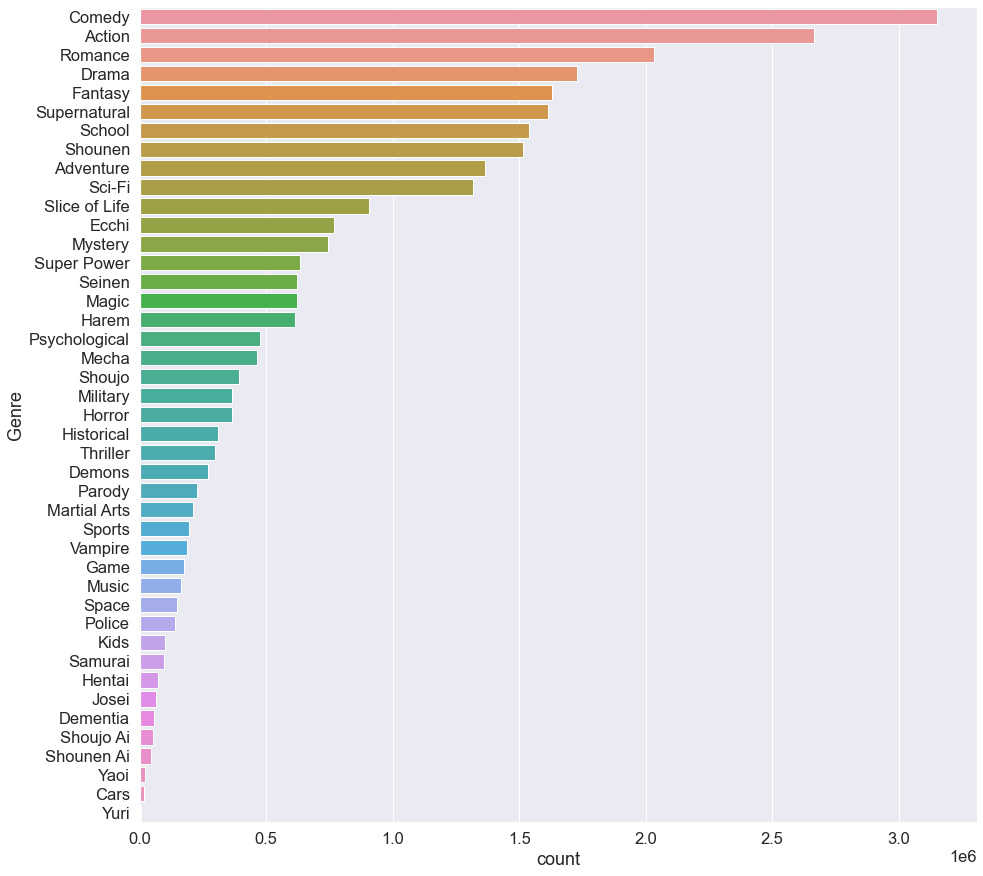

In [62]:
all_genres1=all_genres1.sort_values(by='count',ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(all_genres1['count'],all_genres1['Genre'])

# Data Preprocessing

In [63]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [64]:
genres = anime['genre'].str.split(',', expand=True)
genres.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Drama,Romance,School,Supernatural,None,None,None,None,None,None,None,None,None
1,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,None,None,None,None,None,None
2,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
3,Sci-Fi,Thriller,None,None,None,None,None,None,None,None,None,None,None
4,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None


In [65]:
# considering only first four genres columns 
genres = genres.iloc[:,:4]
genres.columns = ['genre1', 'genre2', 'genre3','genre4']
genres.head()

,genre1,genre2,genre3,genre4
0,Drama,Romance,School,Supernatural
1,Action,Adventure,Drama,Fantasy
2,Action,Comedy,Historical,Parody
3,Sci-Fi,Thriller,None,None
4,Action,Comedy,Historical,Parody


In [66]:
updated_rating=anime.copy()

In [67]:
updated_rating = updated_rating.drop('genre', axis=1) 
updated_rating = pd.concat([updated_rating, genres], axis=1)
updated_rating.head()

,anime_id,name,type,episodes,rating,members,genre1,genre2,genre3,genre4
0,32281,Kimi no Na wa,Movie,1,9.37,200630,Drama,Romance,School,Supernatural
1,5114,Fullmetal Alchemist Brotherhood,TV,64,9.26,793665,Action,Adventure,Drama,Fantasy
2,28977,Gintama°,TV,51,9.25,114262,Action,Comedy,Historical,Parody
3,9253,SteinsGate,TV,24,9.17,673572,Sci-Fi,Thriller,None,None
4,9969,Gintama039,TV,51,9.16,151266,Action,Comedy,Historical,Parody


In [68]:
updated_rating['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

In [69]:
updated_rating.episodes=updated_rating.episodes.astype('int')

In [70]:
df_cat = updated_rating.select_dtypes(np.object)
df_num = updated_rating.select_dtypes(np.number)

In [71]:
df_dum = pd.get_dummies(df_cat[['type','genre1','genre2','genre3','genre4']])
df_dum.head()

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre1_Action,genre1_Adventure,genre1_Cars,genre1_Comedy,...,genre4_ Shounen Ai,genre4_ Slice of Life,genre4_ Space,genre4_ Sports,genre4_ Super Power,genre4_ Supernatural,genre4_ Thriller,genre4_ Vampire,genre4_ Yaoi,genre4_ Yuri
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Recommendation system 

## Popularity Based recommendation system 

In [72]:
df_data.head()

,anime_id,name,genre,type,episodes,avg_rating,members,user_id,user_rating,totalRatingCount
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5.0,1961
1,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10.0,1961
2,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10.0,1961
3,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10.0,1961
4,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10.0,1961


In [73]:
rating1=df_data[['anime_id','name','genre','avg_rating','totalRatingCount']]
rating1.drop_duplicates(subset=['anime_id'],inplace=True)
rating1.reset_index(drop=True,inplace=True)

In [74]:
rating1.shape

(9890, 5)

In [75]:
# mean rating across all the animes
C = rating1['avg_rating'].mean()
# animes having total rate count greater than 85%
m = rating1['totalRatingCount'].quantile(0.85)
print('m: ', m, 'C: ', C)

m:  987.6499999999996 C:  6.592642062689574


In [76]:
def weighted_rating(x, m=m, C=C):
    v = x['totalRatingCount']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [77]:
# animes having total rate count greater than 85% is considered into lists_animes
lists_animes =rating1.copy().loc[rating1['totalRatingCount'] >= m]
lists_animes.shape

(1484, 5)

In [78]:
# Define a new feature 'score' and calculate its value with `Iighted_rating()`
lists_animes['score'] = lists_animes.apply(weighted_rating, axis=1)

In [79]:
lists_animes.head()

,anime_id,name,genre,avg_rating,totalRatingCount,score
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",9.37,1961,8.439724
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26,21494,9.142819
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25,1188,8.043676
3,9253,SteinsGate,"Sci-Fi, Thriller",9.17,17151,9.029663
4,9969,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",9.16,3115,8.541948


In [80]:
#Sort movies based on score calculated above
lists_animes = lists_animes.sort_values('score', ascending=False)

#Print the top 10 movies
lists_animes[['name', 'totalRatingCount', 'avg_rating', 'score']].head(10)

,name,totalRatingCount,avg_rating,score
1,Fullmetal Alchemist Brotherhood,21494,9.26,9.142819
3,SteinsGate,17151,9.17,9.029663
10,Clannad After Story,15518,9.06,8.912360
13,Code Geass Hangyaku no Lelouch R2,21124,8.98,8.873365
6,Hunter x Hunter 2011,7477,9.13,8.833943
15,Sen to Chihiro no Kamikakushi,19481,8.93,8.817218
19,Code Geass Hangyaku no Lelouch,24125,8.83,8.742007
16,Shigatsu wa Kimi no Uso,8271,8.92,8.671733
22,Cowboy Bebop,13449,8.82,8.667620
24,Mononoke Hime,13679,8.81,8.660683


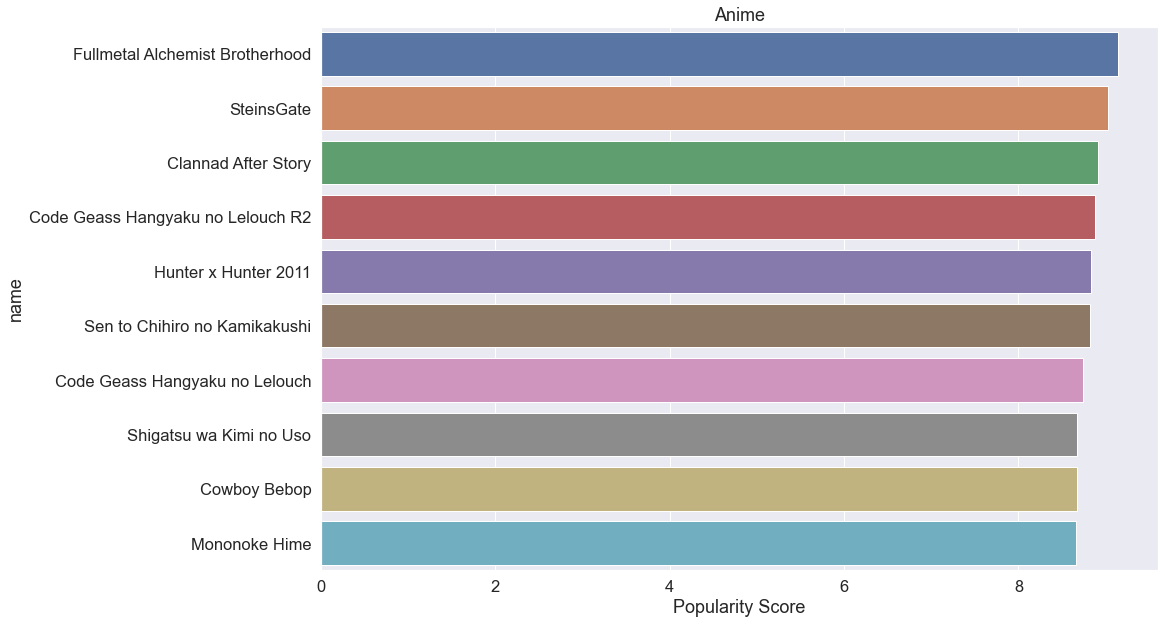

In [81]:
pop=lists_animes[['name', 'totalRatingCount', 'avg_rating', 'score']].head(10)
plt.figure(figsize=(15,10))
sns.barplot(pop['score'],pop['name'])
plt.title('Anime')
plt.xlabel('Popularity Score')
plt.show()

The above plot shows top 10 animes which can be recommended based on trend.

## Content based Recommendation System 

In [82]:
m1 = anime.members.quantile(0.75)
C1 = anime.rating.mean()
print(m1, C1)

9832.0 6.48460862214709


In [83]:
def weighted_rating1(df, m1, C1):
    term = df['members'] / (m1 + df['members'])
    return df['rating'] * term + (1-term) * C1

In [85]:
anime['community_rating'] = anime.apply(weighted_rating1, axis=1, args=(m,C))
anime.drop(['anime_id', 'rating', 'members', 'episodes'], axis=1, inplace=True)
anime.head()

,name,genre,type,community_rating
0,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,9.356395
1,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.256685
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.227227
3,SteinsGate,"Sci-Fi, Thriller",TV,9.166226
4,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.143346


In [86]:
anime = pd.concat([anime, anime['type'].str.get_dummies(), anime['genre'].str.get_dummies(sep=',')], axis=1)
anime.head()

,name,genre,type,community_rating,Movie,Music,ONA,OVA,Special,TV,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,9.356395,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.256685,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.227227,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,SteinsGate,"Sci-Fi, Thriller",TV,9.166226,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Gintama039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.143346,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [87]:
anime_features = anime.loc[:, "Movie":].copy()
anime_features.head()

,Movie,Music,ONA,OVA,Special,TV,Adventure,Cars,Comedy,Dementia,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
cosine_sim = cosine_similarity(anime_features.values, anime_features.values)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31622777],
       [0.        , 1.        , 0.375     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.375     , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.31622777, 0.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ]])

In [89]:
anime_index = pd.Series(anime.index, index=anime.name)

In [90]:
def get_recommendation(anime_name, similarity=cosine_sim):
    idx = anime_index[anime_name]
    
    # Get the pairwsie similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime
    sim_scores = sim_scores[0:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar anime
    result = anime[['name', 'genre', 'community_rating']].iloc[anime_indices].drop(idx)
    return result

In [91]:
get_recommendation("SteinsGate")

,name,genre,community_rating
3581,Fireball Charming,Sci-Fi,6.888237
7984,Hanoka,Sci-Fi,5.127987
8910,Hoshi no Ko Poron,Sci-Fi,6.610368
10079,RoboDz,Sci-Fi,6.413718
10858,Yuusei Kamen,Sci-Fi,6.578227
59,SteinsGate Movie Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller",8.599698
126,SteinsGate Oukoubakko no Poriomania,"Sci-Fi, Thriller",8.448512
196,SteinsGate Kyoukaimenjou no Missing Link Divi...,"Sci-Fi, Thriller",8.295902
250,Zankyou no Terror,"Psychological, Thriller",8.255211
2143,Figure 17 Tsubasa amp Hikaru,"Sci-Fi, Slice of Life",7.245943


## Collaberative filtering Recommendation System

In [92]:
df.shape

(6337137, 9)

In [93]:
df.duplicated(subset=['user_id','name']).sum()

31779

In [94]:
df1=df.copy()
df1.drop_duplicates(subset=['user_id','name'],inplace=True)

In [95]:
df1.reset_index(drop=True,inplace=True)

In [96]:
counts = df1['user_id'].value_counts()
anime_feature = df1[df1['user_id'].isin(counts[counts >= 500].index)]

In [97]:
anime_feature.shape

(989534, 9)

In [98]:
# user-item matrix
df_pivot = anime_feature.pivot(index='name', columns='user_id', values='user_rating')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

user_id,226,271,294,392,446,478,661,741,771,786,...,73234,73272,73286,73340,73356,73362,73378,73395,73499,73502
name,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009 ReCyborg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
df_pivot.shape

(9539, 1345)

### Memory based Recommendation System (Similar anime) Using KNN

In [100]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(df_pivot)

NearestNeighbors(metric='cosine')

In [101]:
distances, indices = model_knn.kneighbors(df_pivot, n_neighbors=6)

In [102]:
recommend = pd.DataFrame(indices, columns=['anime0', 'anime1', 'anime2', 'anime3', 'anime4', 'anime5'])
recommend.head()

,anime0,anime1,anime2,anime3,anime4,anime5
0,0,6279,7055,1601,1877,5863
1,1,4278,4307,4277,4066,4324
2,2,2412,3420,8035,283,6558
3,3,1463,5195,8342,511,546
4,4,5,64,1261,2810,3074


In [103]:
recommend2 = recommend.copy()
for i in range(0, 6):
    animes = pd.DataFrame(df_pivot.index).reset_index()
    animes = animes.rename(columns={'index':f'anime{i}'})
    recommend2 = pd.merge(recommend2, animes, on=[f'anime{i}'], how='left')
    recommend2 = recommend2.drop(f'anime{i}', axis=1)
    recommend2 = recommend2.rename(columns={'name':f'anime{i}'})

In [104]:
recommend2.head(10)

,anime0,anime1,anime2,anime3,anime4,anime5
0,0,Oosouji,Rusty Nail,Decorator,Doudou,Nebula feat Hatsune Miku
1,0008,Kinyoru Abe Reiji Heikinteki na Salaryman no I...,Kissaten Soudou,Kinyoru Abe Reiji Heikinteki na Salaryman no I...,Kaseifu ga Ita,Kittychan wo Sagase Toyamashi Stamp Rally
2,001,Gakuen Senki Muryou,Hyoutan Suzume,Sun Set Sun,Ame no Bus Stophen,Pihyara Kouta
3,009 ReCyborg,Cyborg 009,Mardock Scramble The First Compression,Terra e,Arve Rezzle Kikaijikake no Youseitachi,Asura
4,0091,0091 RampB,AIKa,Choujuushin Gravion,Gun Frontier,HeatGuy J
5,0091 RampB,0091,Glass no Kantai La Legende du Vent de l039Univ...,GTaste 2010,AIKa Zero,AIKa
6,07Ghost,Kuroshitsuji,Pandora Hearts,DGrayman,Nabari no Ou,Vampire Knight
7,1000nen Joou Queen Millennia,Maetel Legend,Uchuu Koukyoushi Maetel Ginga Tetsudou 999 Gaiden,Queen Emeraldas,Ginga Tetsudou 999 Kimi wa Haha no You ni Aise...,Cosmo Warrior Zero
8,1001 Nights,Kataku,Doujouji,Aru Tabibito no Nikki,Aru Tabibito no Nikki Specials,Memory
9,100mannen Chikyuu no Tabi Bander Book,Love Position Halley Densetsu,Bremen 4 Jigoku no Naka no Tenshitachi,Maken Liner 0011 Henshin Seyo,Ginga Tansa 2100nen Border Planet,Super Kid


The above table shows the 5 similar animes for each anime.

# Conclusion


- For a new user popularity based and content based recommender works well, later based on user activities, collaborative based and association recommenders performs better.

- A  better  anime  recommendation  system is when I consider user  watch  history.So collaborative based filtering (model-based) recommendation model would be best for recommending animes to the users.